Number of unique categories: 24
Number of unique web services: 141


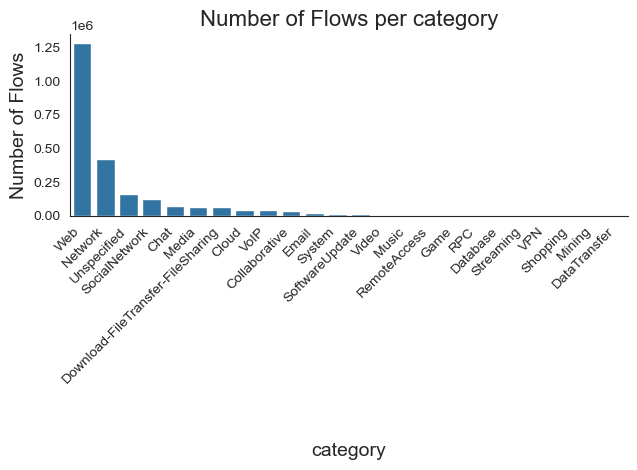

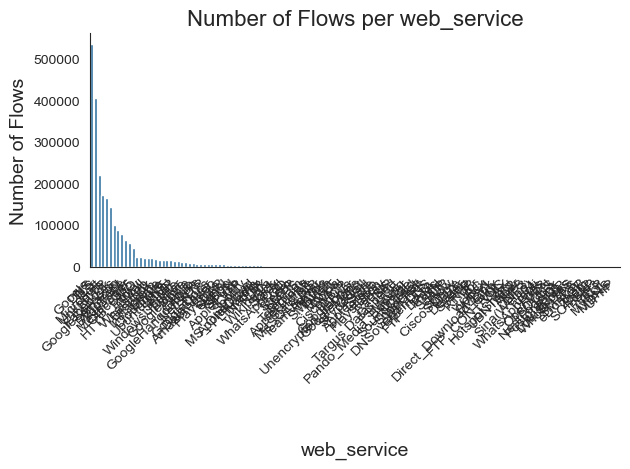

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "../../web_service_dataset.csv"
df = pd.read_csv(file_path)
# 1.1
unique_categories = df['category'].unique()
unique_web_services = df['web_service'].unique()

print(f"Number of unique categories: {len(unique_categories)}")
print(f"Number of unique web services: {len(unique_web_services)}")

df_categories = ['category', 'web_service']


for elem in df_categories:
    flow_by_elem = df.groupby(elem)['flow_key'].nunique().sort_values(ascending=False)
    sns.set_style("white")
    sns.barplot(x=flow_by_elem.index, y=flow_by_elem.values)
    plt.title(f'Number of Flows per {elem}', fontsize=16)
    plt.xlabel(f'{elem}', fontsize=14, labelpad=40)
    plt.ylabel("Number of Flows", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.tight_layout()
    plt.show()